In [1]:
import math
from cmath import sin, cos, phase

In [2]:
from pauliopt.phase import PhaseCircuit, PhaseGadget, Z, X
from pauliopt.utils import pi, Angle
from pauliopt.topologies import Topology

20


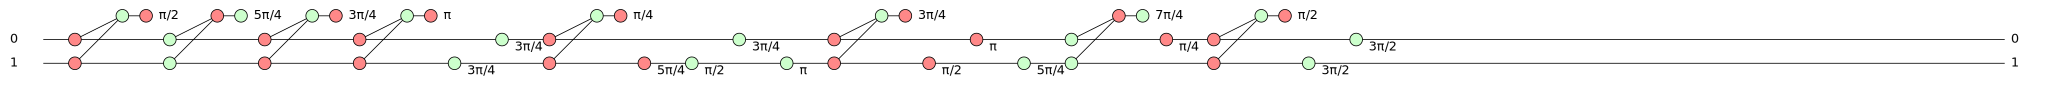

In [3]:
topology = Topology.grid(2, 1)
circuit = PhaseCircuit.random(topology.num_qubits, 20, min_legs=1, max_legs=2, rng_seed=1)
print(len(circuit))
circuit

17


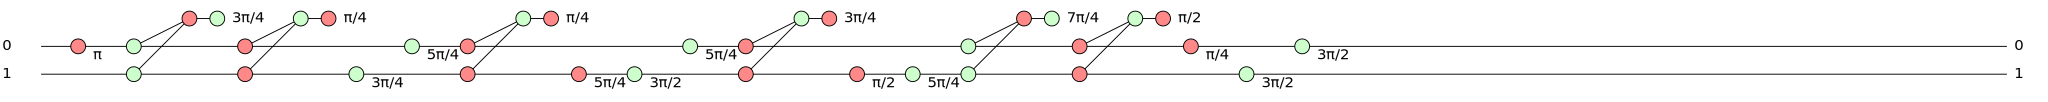

In [4]:
simpl = circuit.simplified()
print(len(simpl))
simpl

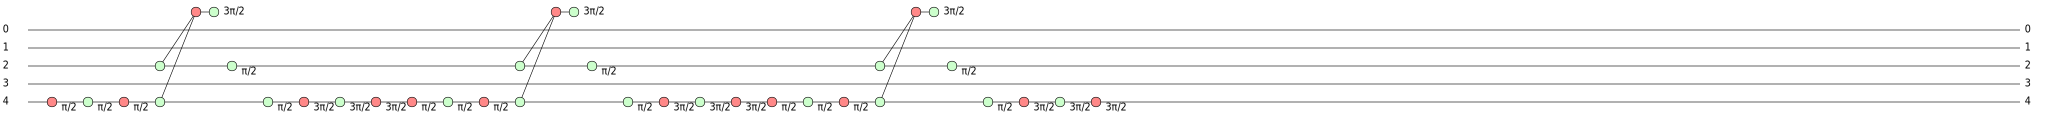

In [5]:
circ = PhaseCircuit(5)
circ.cx(2, 4)
circ.cx(2, 4)
circ.cx(2, 4)
circ

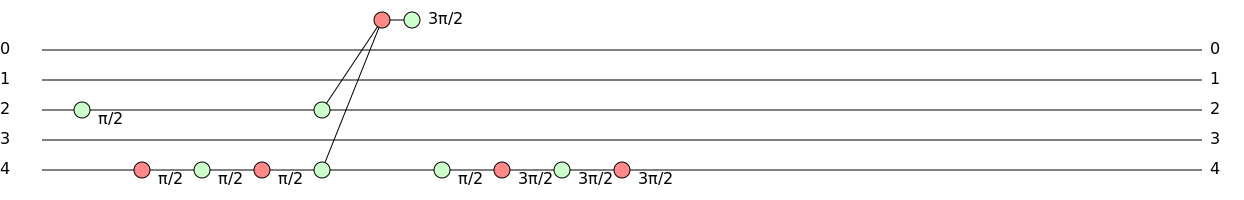

In [6]:
simpl = circ.simplified()
simpl

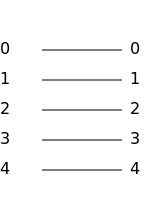

In [7]:
circ.simplified().h(4).cz(2, 4).h(4).simplified()

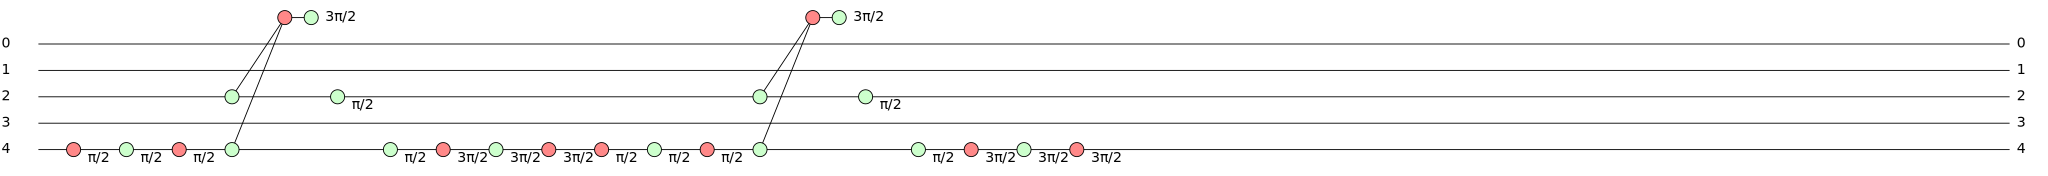

In [8]:
circ1 = PhaseCircuit(5)
circ1.cx(2, 4)
circ1.cx(2, 4)

In [9]:
def peephole(circuit):
    def peep(l, start):
        i = start
        while i < len(l):
            while l[i].angle == 2*pi:
                l.pop(i)
                return peep(l, start=max(0, i-1))
            if i != len(l)-1:
                if l[i].basis == l[i+1].basis and l[i].qubits == l[i+1].qubits:
                    basis = Z if l[i].basis == 'Z' else X
                    total_angle = l[i].angle + l[i+1].angle
                    l[i] = basis(total_angle) @ l[i].qubits
                    l.pop(i+1)
                    return peep(l, start=i)
            i += 1
    
    l = list(circuit.gadgets)
    peep(l, start=0)
    return PhaseCircuit(circuit.num_qubits, l)

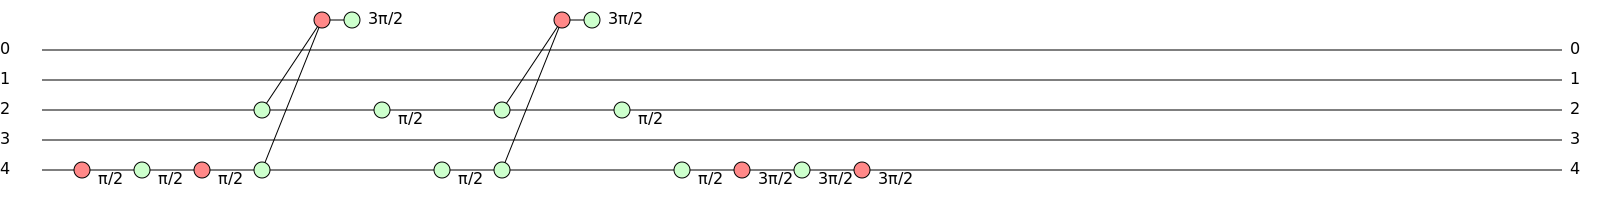

In [10]:
circ2 = peephole(circ1)
circ2

In [11]:
def group_pi(table):
    """ groups pi gates into one large pi gadget """
    pi_qubits = set()
    keys_to_remove = []
    for qubits, phase in table.items():
        if phase == pi:
            pi_qubits ^= qubits
            keys_to_remove.append(qubits)
    
    for key in keys_to_remove:
        del table[key]
    pi_key = frozenset(pi_qubits)
    if len(pi_key) > 0:
        table[pi_key] = table.get(pi_key, Angle(0)) + pi

In [12]:
def aggregate(circuit):
    """
    Combine the gadgets into layers of same colour gadgets,
    potentially applying spider nest identites as well
    """
    if circuit.num_gadgets == 0:
        return []
    l = circuit.gadgets
    
    current_basis = l[0].basis
    table = dict()
    blocks = [(current_basis, table)]
    
    for gadget in l:
        basis, qubits, angle = gadget.basis, gadget.qubits, gadget.angle
        if basis == current_basis:
            table[qubits] = table.get(qubits, Angle(0)) + angle
        else:
#             spider_nest(table)
            group_pi(table)
            current_basis = basis
            table = {qubits: angle}
            blocks.append((current_basis, table))
        group_pi(table)
    
    
    new_circuit = PhaseCircuit(circuit.num_qubits)
    
    for basis, table in blocks:
        basis_cls = Z if basis == 'Z' else X
        for qubits, angle in table.items():
            if angle == 2*pi:
                continue
            new_circuit >>= basis_cls(angle) @ qubits
            
    return new_circuit

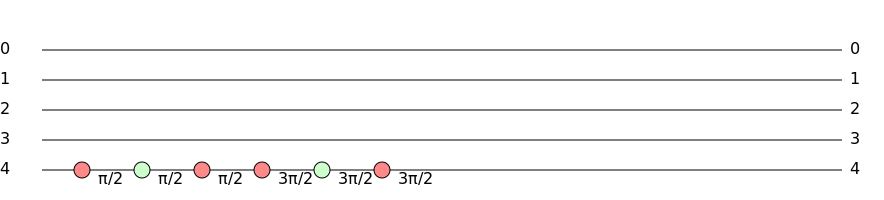

In [13]:
circ3 = aggregate(circ2)
circ3

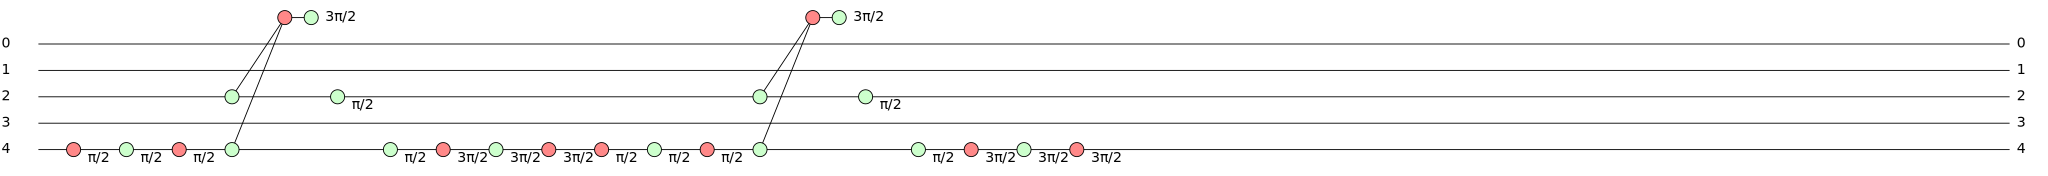

In [15]:
circ1

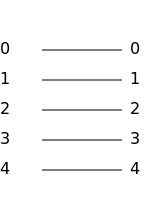

In [16]:
circ1.simplified()

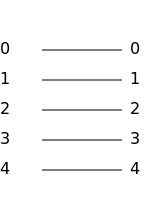

In [17]:
peephole(circ3)

In [18]:
def spider_nest(table):
    # see https://arxiv.org/pdf/2004.05164.pdf
    pass

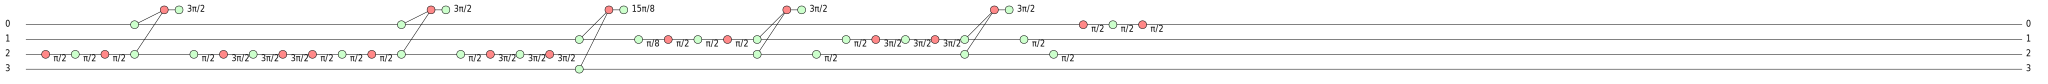

In [19]:
new_circ = PhaseCircuit(4)
new_circ.crx(0,2,pi).crx(0,2,pi).crz(3,1,pi/4).cx(2,1).cz(1,2).h(0)
# new_circ.crx(0,2,pi).crx(0,2,pi)

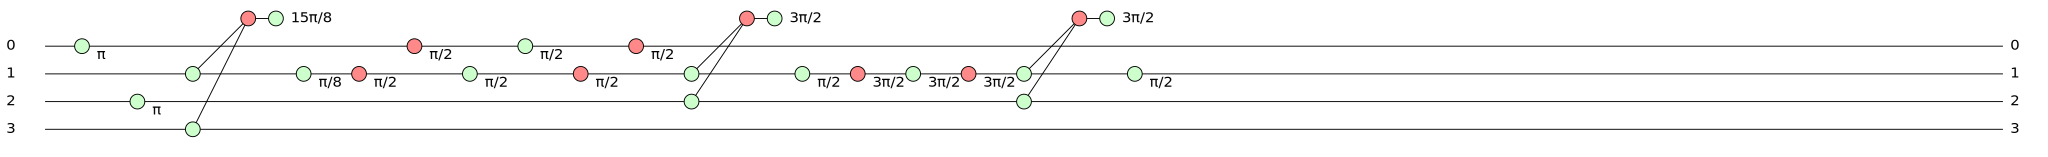

In [20]:
new_circ.simplified()

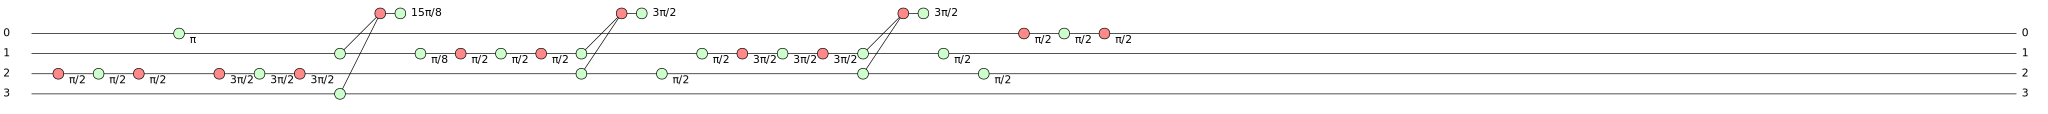

In [21]:
def simp_circ(circ):
    for i in range(1):
        circ = peephole(circ)
        circ = aggregate(circ)
    return circ

simp_circ(new_circ)

In [22]:
def commute(circuit):
    """ Apply commutation relations to group same-colored gadgets """
    l = list(circuit.gadgets)
    
    for i, gadget1 in enumerate(l):
        j = i-1
        basis1, qubits1 = gadget1.basis, gadget1.qubits
        while j >= 0:
            gadget2 = l[j]
            basis2, qubits2 = gadget2.basis, gadget2.qubits
            
            if basis1 != basis2 and len(qubits1 & qubits2) % 2 == 0:
                j -= 1
            else:
                break
        
        if j != i-1:
            l.pop(i)
            l.insert(j+1, gadget1)
    return PhaseCircuit(circuit.num_qubits, l)

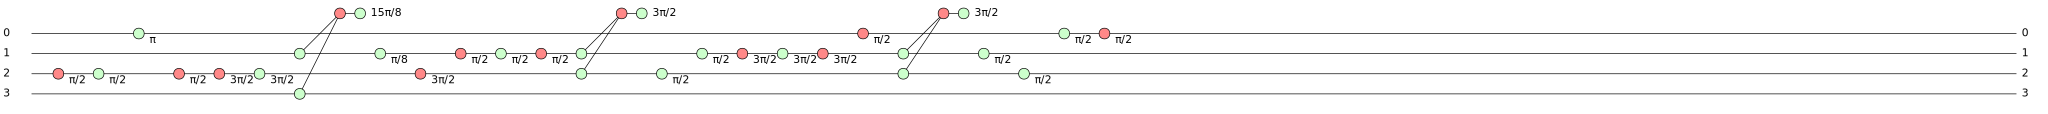

In [23]:
commute(simp_circ(new_circ))

In [24]:
def round_near_pi(angle):
    multiple = angle * 8 / math.pi
    if round(multiple) - multiple < 1e-10:
        return Angle(pi / 8 * round(multiple))
    return angle

def eu(a1, a2, a3, accurate=True):
    h1, h2, h3 = (a1/2, a2/2, a3/2)
    
    xp = h1 + h3
    xm = h1 - h3
    
    z1 = cos(h2)*cos(xp) + 1j*sin(h2)*cos(xm)
    z2 = cos(h2)*sin(xp) - 1j*sin(h2)*sin(xm)
    
    b1 = phase(z1) + phase(z2)
    b2 = 2*phase(abs(z1) + 1j*abs(z2))
    b3 = phase(z1) - phase(z2)
    
#     return Angle(b1), Angle(b2), Angle(b3)
    return list(map(round_near_pi, [b1, b2, b3]))

In [25]:
eu(pi, pi/2, pi/2)

[Angle.pi/2, Angle.pi/2, Angle.pi]

In [26]:
def euler_gadgets_long(circuit):
    l = list(circuit.gadgets)
    
    i = 0
    while i < len(l)-3:
        positions = [i]
        g_qubits, g_basis = l[i].qubits, l[i].basis
        j = i+1
        while j < len(l):
            new_qubits, new_basis = l[j].qubits, l[j].basis
            if not (g_basis == new_basis or (overlap := len(g_qubits & new_qubits)) == 0):
                if overlap % 2 == 1:
                    positions.append(j)
                    g_basis = new_basis
                    if len(positions) == 4:
                        break
            j += 1
        if len(positions) != 4:
            i += 1
            continue
        print("found", positions)
        
        gadgets = [l[x] for x in positions]
        
        a1, a2, a3, a4 = map(lambda x: x.angle, gadgets)
        q1, q2, q3, q4 = map(lambda x: x.qubits, gadgets)
        c1, c2, c3, c4 = map(lambda x: x.basis, gadgets)
        # check alternating colors
        if c1 == c3 and c2 == c4 and c1 != c2:
            # matching legs for matching colours
            if q1 == q3 and q2 == q4:
                new_basis1, new_basis2 = [Z if basis == 'Z' else X for basis in [c2, c1]]
                new_legs1, new_legs2 = q2, q1
                
                b1, b2, b3 = eu(a1, a2, a3)
                b3 += a4
                g1 = new_basis1(b1) @ new_legs1
                g2 = new_basis2(b2) @ new_legs2
                g3 = new_basis1(b3) @ new_legs1
                
                for x in reversed(positions):
                    l.pop(x)
                
                l = l[:i] + [g1, g2, g3] + l[i:]
                i -= 1
        i += 1
    return PhaseCircuit(circuit.num_qubits, l)

In [27]:
def euler_gadgets(circuit):
    l = list(circuit.gadgets)
    
    i = 0
    while i < len(l)-3:
        a1, a2, a3, a4 = map(lambda x: x.angle, l[i:i+4])
        q1, q2, q3, q4 = map(lambda x: x.qubits, l[i:i+4])
        c1, c2, c3, c4 = map(lambda x: x.basis, l[i:i+4])
        # check alternating colors
        if c1 == c3 and c2 == c4 and c1 != c2:
            # matching legs for matching colours
            if q1 == q3 and q2 == q4:
                new_basis1, new_basis2 = [Z if basis == 'Z' else X for basis in [c2, c1]]
                new_legs1, new_legs2 = q2, q1
                
                b1, b2, b3 = eu(a1, a2, a3)
                b3 += a4
                g1 = new_basis1(b1) @ new_legs1
                g2 = new_basis2(b2) @ new_legs2
                g3 = new_basis1(b3) @ new_legs1
                
                l = l[:i] + [g1, g2, g3] + l[i+4:]
                i -= 1
        i += 1
    return PhaseCircuit(circuit.num_qubits, l)

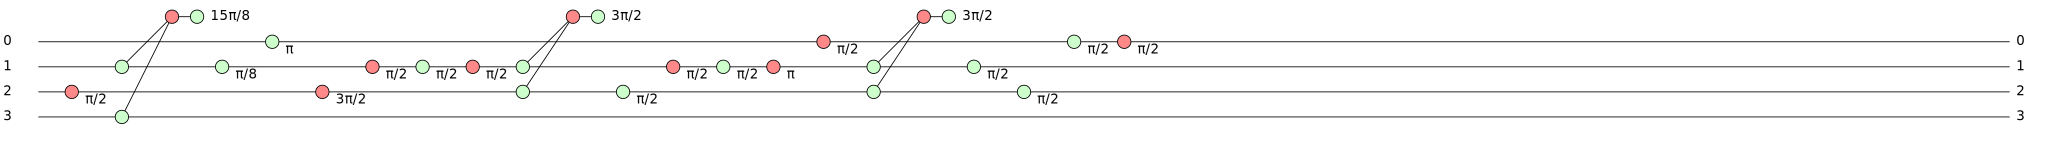

In [28]:
simped_circ = simp_circ(commute(simp_circ(new_circ)))
euler_gadgets(simped_circ)

found [1, 5, 6, 7]
found [2, 5, 6, 7]
found [2, 3, 4, 7]
found [3, 4, 7, 10]
found [4, 7, 10, 11]
found [5, 13, 17, 18]
found [9, 12, 13, 14]
found [11, 12, 13, 14]
found [11, 12, 13, 14]


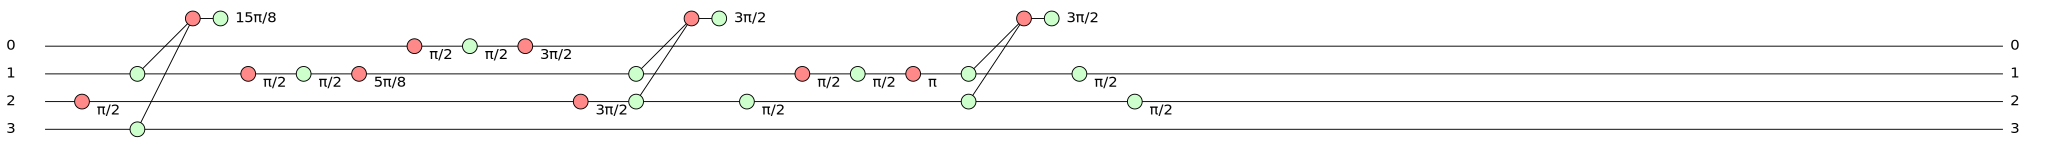

In [29]:
simped_circ = simp_circ(commute(simp_circ(new_circ)))
euler_gadgets_long(simped_circ)

33 -> 20
33 -> 17


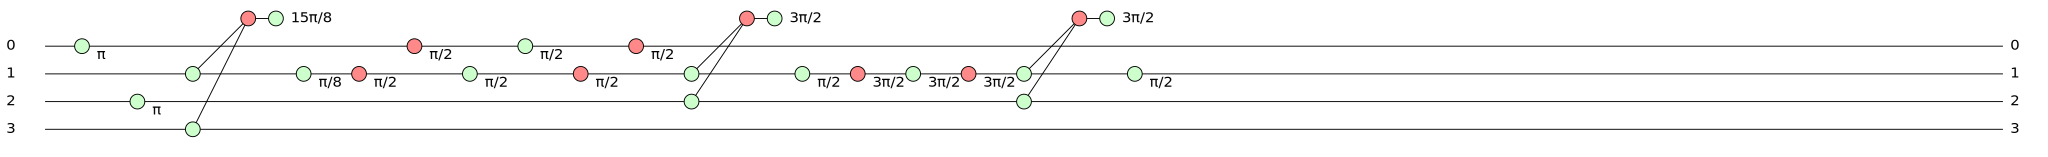

In [30]:
print(f"{len(new_circ)} -> {len(simped_circ)}")
print(f"{len(new_circ)} -> {len(new_circ.simplified())}")
new_circ.simplified()

In [31]:
eu(pi, pi/2, pi/2)

[Angle.pi/2, Angle.pi/2, Angle.pi]

TODO
- pi push for single pis
- EU for single qubits (do 4 range search better)
